# Sentinel-2 Image Retrieval Using Google Earth Engine

To retrieve Sentinel-2 images from Google Earth Engine, make sure you create an account and authenticate prior to running the cell below. The link to sign up is [here](https://earthengine.google.com/new_signup/).



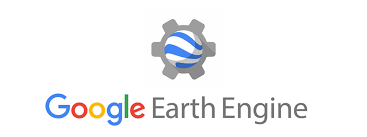

To download Sentinel-2 images we will be using the module <code>ee_download</code> and interact with the map using <code>geemap.eefolium</code>.

We use the AOI polygons retrieved from CopernicusEMS to select the location and time that we are interested in and use Google Earth Engine to do the georeferencing. Notice that we may also render the hydrography and observed flood event.

In [1]:
# Path based modules to allow us to save files to our local machine
from pyprojroot import here
import sys
import os
root = here(project_files=[".here"])
sys.path.append(str(here()))

In [2]:
from datetime import timedelta
from datetime import datetime
import geopandas as gpd
import pandas as pd
import ee
import geemap.eefolium as geemap
import folium
from src.data import ee_download, utils
from src.data.copernicusEMS import activations


In [3]:
floodmap_geojson = "gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/floodmap/EMSR495/AOI01/EMSR495_AOI01_DEL_MONIT01_r1_v1_floodmap.geojson"
# geojson_filepath = f"{root}/datasets/Copernicus_EMS_raw/{floodmap_geojson}"
floodmap = gpd.read_file(floodmap_geojson)
meta_floodmap_filepath = "gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/flood_meta/EMSR495/AOI01/EMSR495_AOI01_DEL_MONIT01_r1_v1_metadata_floodmap.pickle"
metadata_floodmap = utils.read_pickle_from_gcp(meta_floodmap_filepath)

floodmap


# meta_floodmap_pkl = "metadata_floodmap.pickle"
# #meta_floodmap_filepath = f"{root}/datasets/Copernicus_EMS_raw/{meta_floodmap_pkl}"
# with open(meta_floodmap_filepath, 'rb') as filehandle:
#     # read the data as binary data stream
#     metadata_floodmap = pickle.load(filehandle)

w_class            source  \
0        Flooded area             flood   
1        Flooded area             flood   
2        Flooded area             flood   
3        Flooded area             flood   
4        Flooded area             flood   
..                ...               ...   
482      BH141-Stream           hydro_l   
483      BH141-Stream           hydro_l   
484      BH141-Stream           hydro_l   
485      BH141-Stream           hydro_l   
486  area_of_interest  area_of_interest   

                                              geometry  
0    POLYGON ((33.46727 -24.76323, 33.46727 -24.763...  
1    POLYGON ((33.53597 -24.71282, 33.53597 -24.712...  
2    POLYGON ((33.53019 -24.71423, 33.53019 -24.714...  
3    POLYGON ((33.52663 -24.71489, 33.52663 -24.714...  
4    POLYGON ((33.53686 -24.71845, 33.53686 -24.718...  
..                                                 ...  
482  LINESTRING (33.56876 -25.04945, 33.56846 -25.0...  
483  LINESTRING (33.68826 -24.92369, 33.68796 -24.9...  
484  LINESTRING (33.62279 -24.93672, 33.62166 -24.9...  
485  LINESTRING (33.65499 -24.75138, 33.65191 -24.7...  
486  POLYGON ((33.65262 -24.74752, 33.72686 -24.868...  

[487 rows x 3 columns]

In [4]:
metadata_floodmap

{'event_id': 'EMSR495_AOI01_DEL_MONIT01_r1_v1',
 'layer_name': 'EMSR495_AOI01_DEL_MONIT01_observedEventA_r1_v1',
 'event_type': 'Coastal flood',
 'satellite_date': Timestamp('2021-01-24 16:22:28+0000', tz='UTC'),
 'country': 'NaN',
 'satellite': 'Sentinel-1',
 'bounding_box': {'west': 33.454061058000036,
  'east': 33.705909407000036,
  'north': -24.712656954999943,
  'south': -25.18645625499994},
 'reference_system': {'code_space': 'epsg', 'code': '4326'},
 'abstract': 'NaN',
 'purpose': 'NaN',
 'source': 'CopernicusEMS',
 'area_of_interest_polygon': <shapely.geometry.polygon.Polygon at 0x7f3d272b6cd0>,
 'observed_event_file': 'EMSR495_AOI01_DEL_MONIT01_observedEventA_r1_v1.shp',
 'area_of_interest_file': 'EMSR495_AOI01_DEL_MONIT01_areaOfInterestA_r1_v1.shp',
 'ems_code': 'EMSR495',
 'aoi_code': 'AOI01',
 'satellite_pre_event': 'Sentinel-2',
 'timestamp_pre_event': Timestamp('2020-08-28 07:26:21+0000', tz='UTC'),
 'hydrology_file_a': 'EMSR495_AOI01_DEL_MONIT01_hydrographyA_r1_v1.shp',


In [18]:
%%time
ee.Initialize()

bounds_pol = activations.generate_polygon(metadata_floodmap["area_of_interest_polygon"].bounds)
pol_2_clip = ee.Geometry.Polygon(bounds_pol)

# pol with the real area of interest
x, y = metadata_floodmap["area_of_interest_polygon"].exterior.coords.xy
pol_list = list(zip(x,y))
pol = ee.Geometry.Polygon(pol_list)

date_event = datetime.utcfromtimestamp(metadata_floodmap["satellite_date"].timestamp())

date_end_search = date_event + timedelta(days=20)

# img_col = ee_download.get_s2_collection(date_event, date_end_search, pol)
#img_col = ee_download.get_s2_collection(date_event, date_end_search, pol, collection_name="JRC/GSW1_2/YearlyHistory")

permanent_water_img= ee_download.download_permanent_water(date_event, pol_2_clip)
#sen2
img_col = ee_download.get_s2_collection(date_event, date_end_search, pol)

#collect_filtered, n_images = ee_download.get_collection("JRC/GSW1_2/YearlyHistory", date_event, date_end_search, pol)




CPU times: user 98.7 ms, sys: 4.36 ms, total: 103 ms
Wall time: 810 ms


In [11]:
from rasterio import plot as rasterioplt
import numpy as np

#rgb = np.clip(image[(3,2,1),...]/3000.,0,1)
permanent_water_img.t
#rasterioplt.show(permanent_water_img, transform=None)

dict_keys(['func', 'args', 'varName'])

In [15]:
permanent_water_img?

Type:           Image
String form:   
ee.Image({
           "functionInvocationValue": {
           "functionName": "Image.clip",
           "arguments": {
           <...> tValue": "JRC/GSW1_2/YearlyHistory/2019"
           }
           }
           }
           }
           }
           }
           })
File:           ~/miniconda3/envs/ml4fl_py38/lib/python3.8/site-packages/ee/image.py
Docstring:      An object to represent an Earth Engine image.
Init docstring:
Constructs an Earth Engine image.

Args:
  args: This constructor accepts a variety of arguments:
      - A string - an EarthEngine asset id,
      - A string and a number - an EarthEngine asset id and version,
      - A number - creates a constant image,
      - An ee.Array - creates a constant array image,
      - A list - creates an image out of each element of the array and
        combines them into a single image,
      - An ee.Image - returns the argument,
      - Nothing - results in an empty transparent image.
  vers

In [12]:
n_images_col = permanent_water_img.size().getInfo()
imgs_list = permanent_water_img.toList(n_images_col, 0)

AttributeError: 'Image' object has no attribute 'size'

In [21]:
Map = geemap.Map()
Map.addLayer(permanent_water_img, name="permanent water")
geojson_geojson = "geojson_show.geojson"
geojson_filepath = f"{root}/datasets/Copernicus_EMS_raw/{geojson_geojson}"
utils.create_folder(os.path.dirname(geojson_filepath))
floodmap.to_file(geojson_filepath, driver="GeoJSON")
Map.add_geojson(geojson_filepath, name="FloodMap")

Map.centerObject(pol)
folium.LayerControl(collapsed=False).add_to(Map)
# Map.addLayerControl()
Map

Folder '/home/ahmedn/projects/ml4floods/datasets/Copernicus_EMS_raw' Is Already There.


In [ ]:
n_images_col = img_col.size().getInfo()
# print(f"Found {n_images_col} S2 images between {date_event.isoformat()} and {date_end_search.isoformat()}")
# Map = geemap.Map()

# imgs_list = img_col.toList(n_images_col, 0)
# for i in range(n_images_col):
#     img_show = ee.Image(imgs_list.get(i))
#     # print(img_show.bandNames().getInfo())
#     Map.addLayer(img_show.clip(pol_2_clip), 
#                  {"min":0, "max":3000, "bands":["B4","B3","B2"]},f"S2 {i}", True)

# geojson_geojson = "geojson_show.geojson"
# geojson_filepath = f"{root}/datasets/Copernicus_EMS_raw/{geojson_geojson}"
# utils.create_folder(os.path.dirname(geojson_filepath))
# floodmap.to_file(geojson_filepath, driver="GeoJSON")
# Map.add_geojson(geojson_filepath, name="FloodMap")

# Map.centerObject(pol)
# folium.LayerControl(collapsed=False).add_to(Map)
# # Map.addLayerControl()
# Map

In [13]:
#collect_filtered, n_images
date_event

datetime.datetime(2021, 1, 24, 16, 22, 28)

## Export Sentinel-2 Images to the Google Cloud Bucket

Looking at the S2 images in the map, we see that the second image (S2.1) is the less cloudy of the three images retrieved by the Google Earth Engine. We will export that to the Google bucket to further inspect it. Use <code>task</code> to monitor the status. To run this part of the code you'd need access to the ml4floods Google bucket.

In [13]:
filename

'testingcrap/crap/s2'

In [12]:
import os

BANDS_EXPORT = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA60', 'probability']

img_export = ee.Image(imgs_list.get(1))

img_export = img_export.select(BANDS_EXPORT).toFloat().clip(pol_2_clip) # .reproject(crs,scale=10).resample('bicubic') resample cannot be used on composites

# TODO in the future, change to export to drive and mount the Google drive in colab!

bucket_name= "ml4cc_data_lake"

export_task_fun_img = ee_download.export_task_image(bucket=bucket_name)

filename = os.path.join("testingcrap", "crap", "s2")
desc = os.path.basename(filename) + "S2"
task = ee_download.mayberun(filename, desc,
                            lambda : img_export,
                            export_task_fun_img,
                            overwrite=False, dry_run=False,
                            bucket_name=bucket_name, verbose=2)
if task is not None:
    task.status()

In [26]:
task.status()

{'state': 'COMPLETED',
 'description': 's2S2',
 'creation_timestamp_ms': 1615065142464,
 'update_timestamp_ms': 1615065539437,
 'start_timestamp_ms': 1615065153599,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://console.developers.google.com/storage/browser/ml4cc_data_lake/testingcrap/crap/'],
 'attempt': 1,
 'id': 'ZHTNVGMMBDKKWRZ66SO6HV3S',
 'name': 'projects/earthengine-legacy/operations/ZHTNVGMMBDKKWRZ66SO6HV3S'}

## Retrieve Images from Bucket

To demonstrate that the images have been successfully uploaded to the Google Cloud Storage bucket, we open the image using <code>rasterio</code>. 

In [7]:
from src.data import create_gt
import rasterio

image_name = f"gs://{bucket_name}/{filename}.tif"
with rasterio.open(image_name) as src:
    print(src.shape)
    image = src.read()
    transform = src.transform

image.shape

(384, 1012)


(15, 384, 1012)

In [8]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 10)

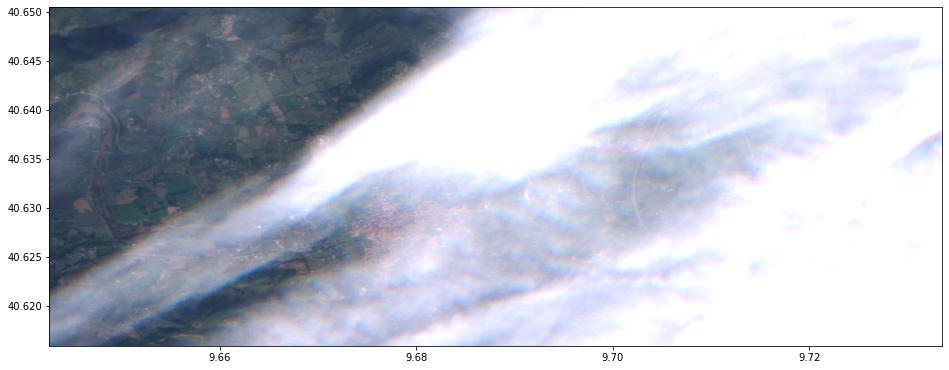

<AxesSubplot:>

In [9]:
from rasterio import plot as rasterioplt
import numpy as np

rgb = np.clip(image[(3,2,1),...]/3000.,0,1)
    
rasterioplt.show(rgb, transform=transform)